## Decoding Neural Network Performance: The Impact of Data Splitting and Class Weighting

In machine learning, the performance of a neural network is hightly influenced by various factors, including how the data is split for training and testing and how class imbalances are addressed. Here we look into an experimental analysis using the same satellite orbital catalog dataset to show how these aspects affect the accuracy of the neural network.


In [37]:
# https://www.kaggle.com/datasets/karnikakapoor/satellite-orbital-catalog

### 1. Essential Libraries and Setup

Again from the previous part, we leverage a standard suite of Python libraries for data manipulation, machine learning, and visualization. `pandas` is instrumental for data handling, `sklearn` provides utilities for data splitting and encoding, and `tensorflow.keras` forms the backbone of our neural network implementation. `matplotlib` and `seaborn` are used for visualizing our results.


In [38]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import class_weight
import tensorflow as tf

We load the same dataset again in the same way as before, and mount it as a pandas dataframe for data manipulation

In [39]:
# download kaggle dataset from google drive, and import as a pandas dataframe
df = pd.read_csv('https://drive.google.com/uc?export=download&id=1i4FdBT71ale29-1ido9Q0HNeNzOZ6lFN')

### 2. Feature Engineering and Preprocessing

Like previous parts, preprocessing is required. We separate the features (`x`) from the target variable (`y`). Descriptive columns, like `norad_id` or `name`, which are not predictive features, are excluded. Categorical features are then transformed into numerical representations using `OrdinalEncoder`, which is nessecary for neural networks that require numerical inputs. The target variable is also encoded to ensure consistency with the model's output layer.


In [40]:
# separate features (x) and target (y)
x = df.drop('congestion_risk', axis=1)
y = df['congestion_risk']

# exclude descriptive columns not used for training data
exclude_columns = ['norad_id', 'name', 'epoch', 'data_source', 'snapshot_date', 'last_seen']
categorical_cols = ['object_type', 'satellite_constellation', 'altitude_category', 'orbital_band', 'orbit_lifetime_category', 'country']

# drop excluded columns
x_processed = x.drop(columns=exclude_columns, errors='ignore')

# use ordinal encoding to change categorical data to numerical for training
encoder = OrdinalEncoder()
x_processed[categorical_cols] = encoder.fit_transform(x_processed[categorical_cols])

# fit the encoder on the entire target variable 'y' to ensure all possible labels are learned
y_encoded_full = encoder.fit_transform(y.values.reshape(-1, 1))
num_classes = len(encoder.categories_[0]) # get the number of unique classes

### 3. Constructing the Neural Network

Like the previous part, our chosen architecture is a simple yet effective Fully Connected (Dense) Neural Network. The `create_nn_model` function defines a sequential model with an input layer, two hidden layers with ReLU activation, and dropout layers to mitigate overfitting. The output layer uses a softmax activation suitable for multi-class classification. The model is compiled with the Adam optimizer and sparse categorical cross-entropy, a common choice for this type of problem.


In [41]:
# define a function to create and compile a new fully connected (dense) neural network model
# a new model is needed each time to avoid training a single model on the same data multiple times, and instead train a new model on a different split of data
def create_nn_model(input_shape, num_classes):
    NNmodel = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,)), # input layer with number of features
        tf.keras.layers.Dropout(0.5), # dropout layer to prevent overfitting
        tf.keras.layers.Dense(64, activation='relu'), # hidden layer
        tf.keras.layers.Dropout(0.3), # dropout layer to prevent overfitting
        tf.keras.layers.Dense(num_classes, activation='softmax') # output layer with number of classes
    ])

    # compile the model
    NNmodel.compile(optimizer='adam', # popular and efficient algorithm
                  loss='sparse_categorical_crossentropy', # sparse categorical cross-entropy is appropriate for multi-class classification problems
                  metrics=['accuracy'])
    return NNmodel


In [42]:
# test how different splits of testing and training data affects the accuracy of the neural network
test_sizes_for_plot = []
accuracies_for_plot = []

### 4. Experiment 1: The Impact of Test Data Size on Accuracy

The ratio of training data to testing data is a foundational decision in machine learning. Too small a test set might not be representative, leading to volatile accuracy estimates. Too large, and the model might not have enough data to learn effectively. Here we systematically vary the test set size from a marginal 0.001 to a substantial 0.8 to see its effect on the neural network's accuracy.

For each test size, a new model is initialized, trained on the respective `x_train`, `y_train_encoded` split, and then evaluated on `x_test`, `y_test_encoded`. This iterative process allows us to collect accuracy metrics across different test data proportions.


In [43]:
# 0.001 test size
x_train, x_test, y_train, y_test = train_test_split(x_processed, y, test_size=0.001, random_state=42)
y_train_encoded = encoder.transform(y_train.values.reshape(-1, 1)).flatten()
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).flatten()

# create a fresh model for this iteration
NNmodel = create_nn_model(x_train.shape[1], num_classes)
NNmodel.fit(x_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
lossNN, accuracyNN = NNmodel.evaluate(x_test, y_test_encoded, verbose=0)
print('NN Test accuracy:', accuracyNN)
test_sizes_for_plot.append(0.001)
accuracies_for_plot.append(accuracyNN)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN Test accuracy: 0.8571428656578064


In [44]:
# 0.01 test size
x_train, x_test, y_train, y_test = train_test_split(x_processed, y, test_size=0.01, random_state=42)
y_train_encoded = encoder.transform(y_train.values.reshape(-1, 1)).flatten()
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).flatten()

# create a fresh model for this iteration
NNmodel = create_nn_model(x_train.shape[1], num_classes)
NNmodel.fit(x_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
lossNN, accuracyNN = NNmodel.evaluate(x_test, y_test_encoded, verbose=0)
print('NN Test accuracy:', accuracyNN)
test_sizes_for_plot.append(0.01)
accuracies_for_plot.append(accuracyNN)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN Test accuracy: 0.8248175382614136


In [45]:
# 0.05 test size
x_train, x_test, y_train, y_test = train_test_split(x_processed, y, test_size=0.05, random_state=42)
y_train_encoded = encoder.transform(y_train.values.reshape(-1, 1)).flatten()
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).flatten()

# create a fresh model for this iteration
NNmodel = create_nn_model(x_train.shape[1], num_classes)
NNmodel.fit(x_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
lossNN, accuracyNN = NNmodel.evaluate(x_test, y_test_encoded, verbose=0)
print('NN Test accuracy:', accuracyNN)
test_sizes_for_plot.append(0.05)
accuracies_for_plot.append(accuracyNN)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN Test accuracy: 0.8105726838111877


In [46]:
# 0.1 test size
x_train, x_test, y_train, y_test = train_test_split(x_processed, y, test_size=0.1, random_state=42)
y_train_encoded = encoder.transform(y_train.values.reshape(-1, 1)).flatten()
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).flatten()

# create a fresh model for this iteration
NNmodel = create_nn_model(x_train.shape[1], num_classes)
NNmodel.fit(x_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
lossNN, accuracyNN = NNmodel.evaluate(x_test, y_test_encoded, verbose=0)
print('NN Test accuracy:', accuracyNN)
test_sizes_for_plot.append(0.1)
accuracies_for_plot.append(accuracyNN)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN Test accuracy: 0.8119029998779297


In [47]:
# 0.2 test size
x_train, x_test, y_train, y_test = train_test_split(x_processed, y, test_size=0.2, random_state=42)
y_train_encoded = encoder.transform(y_train.values.reshape(-1, 1)).flatten()
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).flatten()

# create a fresh model for this iteration
NNmodel = create_nn_model(x_train.shape[1], num_classes)
NNmodel.fit(x_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
lossNN, accuracyNN = NNmodel.evaluate(x_test, y_test_encoded, verbose=0)
print('NN Test accuracy:', accuracyNN)
test_sizes_for_plot.append(0.2)
accuracies_for_plot.append(accuracyNN)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN Test accuracy: 0.8133724927902222


In [48]:
# 0.4 test size
x_train, x_test, y_train, y_test = train_test_split(x_processed, y, test_size=0.4, random_state=42)
y_train_encoded = encoder.transform(y_train.values.reshape(-1, 1)).flatten()
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).flatten()

# create a fresh model for this iteration
NNmodel = create_nn_model(x_train.shape[1], num_classes)
NNmodel.fit(x_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
lossNN, accuracyNN = NNmodel.evaluate(x_test, y_test_encoded, verbose=0)
print('NN Test accuracy:', accuracyNN)
test_sizes_for_plot.append(0.4)
accuracies_for_plot.append(accuracyNN)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN Test accuracy: 0.8166789412498474


In [49]:
# 0.6 test size
x_train, x_test, y_train, y_test = train_test_split(x_processed, y, test_size=0.6, random_state=42)
y_train_encoded = encoder.transform(y_train.values.reshape(-1, 1)).flatten()
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).flatten()

# create a fresh model for this iteration
NNmodel = create_nn_model(x_train.shape[1], num_classes)
NNmodel.fit(x_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
lossNN, accuracyNN = NNmodel.evaluate(x_test, y_test_encoded, verbose=0)
print('NN Test accuracy:', accuracyNN)
test_sizes_for_plot.append(0.6)
accuracies_for_plot.append(accuracyNN)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN Test accuracy: 0.8209649920463562


In [50]:
# 0.8 test size
x_train, x_test, y_train, y_test = train_test_split(x_processed, y, test_size=0.8, random_state=42)
y_train_encoded = encoder.transform(y_train.values.reshape(-1, 1)).flatten()
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1)).flatten()

# create a fresh model for this iteration
NNmodel = create_nn_model(x_train.shape[1], num_classes)
NNmodel.fit(x_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
lossNN, accuracyNN = NNmodel.evaluate(x_test, y_test_encoded, verbose=0)
print('NN Test accuracy:', accuracyNN)
test_sizes_for_plot.append(0.8)
accuracies_for_plot.append(accuracyNN)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN Test accuracy: 0.8212711215019226


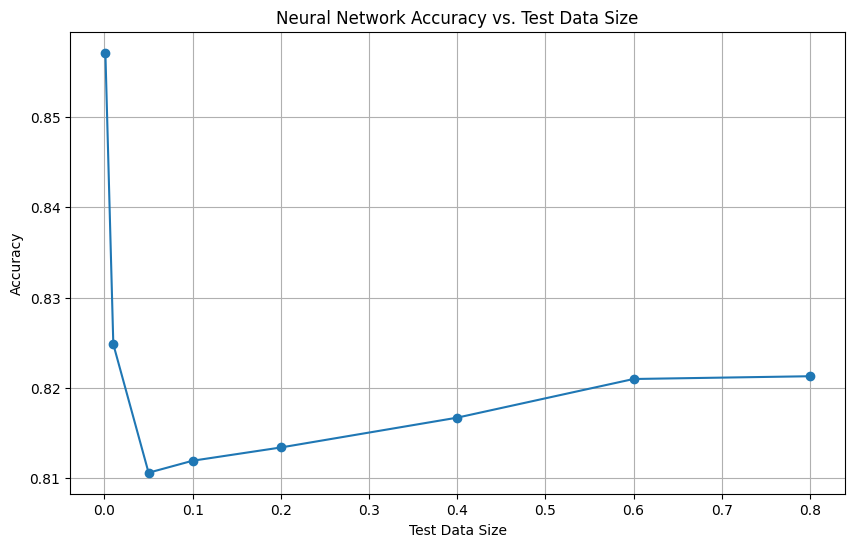

In [51]:
# plotting the results
plt.figure(figsize=(10, 6))
plt.plot(test_sizes_for_plot, accuracies_for_plot, marker='o')
plt.title('Neural Network Accuracy vs. Test Data Size')
plt.xlabel('Test Data Size')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

### 5. Analyzing Test Data Size vs. Accuracy

The plot illustrates an interesting trend. Initially, with very small test sets (e.g., 0.001, 0.01), the accuracy appears higher but, this often signifies a less reliable estimate due to the limited number of samples in the test set. As the test set size increases, the accuracy stabilizes, hovering around 81-82%, which suggests that for this specific dataset and model configuration, the model's performance becomes relatively consistent once the test set is large enough to be statistically representative. The slight dip before stabilization and then a gradual increase for larger test sizes can indicate that while a larger training set (smaller test set) initially allows for better learning, too small a test set struggles with representativeness, and too large a test set reduces the amount of training data, potentially hindering learning.


### 6. Experiment 2: Addressing Class Imbalance with Class Weighting

As with this data set, many real world datasets exhibit class imbalance, where some classes have significantly fewer instances than others. Here there are a large amount of high congestion risk satellites, with small amounts of medium or low congestion risk satellites. Without proper handling, a model might become biased towards the majority class, leading to poor performance on minority classes—even if overall accuracy appears high. This section investigates the effect of class weighting on our neural network, comparing a standard unweighted model against a model trained with balanced class weights.


In [52]:
# show impact of class weighting on the neural network

# create unweighted model
NNmodel_unweighted = create_nn_model(x_train.shape[1], num_classes)
NNmodel_unweighted.fit(x_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2, verbose=0)

y_pred_unweighted = NNmodel_unweighted.predict(x_test)
y_pred_classes_unweighted = np.argmax(y_pred_unweighted, axis=1)

# show classification report for unweighted model
report_unweighted = classification_report(y_test_encoded, y_pred_classes_unweighted)
print("Classification Report (Unweighted Model):")
print(report_unweighted)

# show unweighted model accuracy
loss_unweighted, accuracy_unweighted = NNmodel_unweighted.evaluate(x_test, y_test_encoded, verbose=0)
print('Unweighted NN Test accuracy:', accuracy_unweighted)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification Report (Unweighted Model):
              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90      8942
         1.0       0.00      0.00      0.00       356
         2.0       0.00      0.00      0.00      1590

    accuracy                           0.82     10888
   macro avg       0.27      0.33      0.30     10888
weighted avg       0.67      0.82      0.74     10888



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Unweighted NN Test accuracy: 0.8212711215019226


#### 7. Unweighted Model Performance: A Closer Look at Imbalance

The classification report for the unweighted model reveals a common pitfall of imbalanced datasets. While the overall accuracy is a seemingly good 82.13% and the model performs exceptionally well on the majority class (class 0.0, representing high congestion risk), achieving a perfect recall of 1.00 and a high f1-score of 0.91. However, it completely fails to predict any instances of the minority classes (1.0 medium and 2.0 low congestion risk), resulting in precision, recall, and f1-scores of 0.00 for these classes. This shows a severe bias towards the majority class, rendering the model completely incapable at identifying the less frequent congestion risk levels.


#### 8. Calculating Class Weights

To counteract class imbalance, we calculate `class_weights` using `sklearn.utils.class_weight.compute_class_weight`. This method assigns higher weights to minority classes and lower weights to majority classes, forcing the model to pay more attention to the under-represented samples during training. The resulting dictionary `class_weights_dict` maps each class index to its calculated weight.


In [53]:
# calculate class weights for the training data
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)

# convert the class weights array to a dictionary for use with Keras
class_weights_dict = dict(enumerate(class_weights))

print("Class weights dictionary:")
print(class_weights_dict)

Class weights dictionary:
{0: np.float64(0.4066935604362767), 1: np.float64(9.45138888888889), 2: np.float64(2.29704641350211)}


In [55]:
# train new neural network using these weights
NNmodel_weighted = create_nn_model(x_train.shape[1], num_classes)
NNmodel_weighted.fit(x_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2, verbose=0, class_weight=class_weights_dict)

y_pred_weighted = NNmodel_weighted.predict(x_test)
y_pred_classes_weighted = np.argmax(y_pred_weighted, axis=1)

# create classification report
report_weighted = classification_report(y_test_encoded, y_pred_classes_weighted)
print("Classification Report (Weighted Model):")
print(report_weighted)

# show accuracy of weighted model
loss_weighted, accuracy_weighted = NNmodel_weighted.evaluate(x_test, y_test_encoded, verbose=0)
print('Weighted NN Test accuracy:', accuracy_weighted)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


341/341 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Classification Report (Weighted Model):
              precision    recall  f1-score   support

         0.0       0.87      0.88      0.87      8942
         1.0       0.20      0.96      0.34       356
         2.0       0.97      0.08      0.14      1590

    accuracy                           0.76     10888
   macro avg       0.68      0.64      0.45     10888
weighted avg       0.86      0.76      0.75     10888

Weighted NN Test accuracy: 0.7643277049064636


#### 9. Weighted Model Performance: A Balanced Perspective

Training the neural network with these computed class weights shows a different performance profile. The overall accuracy slightly decreases to 76.43%, but the classification report reveals a more balanced performance. While the majority class (0.0) still performs well, there's a noticeable improvement for class 1. This signifies that the weighted model is, to some extent, capable of identifying instances of this previously entirely ignored minority class. Unfortunately, class 2.0 remains completely unpredicted, with its metrics still at 0.00. This outcome highlights that while class weighting can improve minority class detection, it's not a catch all solution, and extreme imbalances or inherent data characteristics might require further advanced techniques.


### Conclusion: Navigating Data Splits and Imbalances

These experiments show the importance of data splitting strategies and class imbalance handling in developing neural network models. We see that while overall accuracy can be a deceptive metric in the presence of class imbalance, techniques like class weighting can provide a more nuanced and often more valuable performance across all classes, particularly for those that are under-represented. The stability of accuracy across varying test set sizes, once a sufficient size is reached, also provides insights into the model's generalization capabilities.

